In [29]:
# import required dependencies
import pandas as pd
from tensorflow.data import Dataset
import os
from tensorflow.keras import layers
from sklearn.preprocessing import OrdinalEncoder
from preprocess import get_interesting_idx,load_data
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [30]:
warnings.filterwarnings('ignore')

In [31]:
od_encode = OrdinalEncoder()

In [32]:
data = pd.read_excel("19 action.xlsx")
#data = data.query('sign == ["thankyou","happy","hello","mom","dad"]')
od_encode.fit(data[['sign']])
data['sign'] = od_encode.transform(data[["sign"]])[:,0].astype(int)
data['source'] = data['path'] + "$" +data['sign'].astype('str')
data.head()

,path,participant_id,sequence_id,sign,source
0,train_landmark_files/28656/1000106739.parquet,28656,1000106739,15,train_landmark_files/28656/1000106739.parquet$15
1,train_landmark_files/36257/1000536928.parquet,36257,1000536928,2,train_landmark_files/36257/1000536928.parquet$2
2,train_landmark_files/32319/1001958254.parquet,32319,1001958254,8,train_landmark_files/32319/1001958254.parquet$8
3,train_landmark_files/26734/100225301.parquet,26734,100225301,3,train_landmark_files/26734/100225301.parquet$3
4,train_landmark_files/53618/1004317038.parquet,53618,1004317038,6,train_landmark_files/53618/1004317038.parquet$6


In [33]:
n_class = data.sign.nunique()

In [8]:
X_train, X_test, y_train,y_test = train_test_split(data['source'],data['sign'],test_size=0.2,random_state=10,stratify=data['sign'])

In [9]:
X_test, X_val, y_test,y_val = train_test_split(X_test,y_test,test_size=0.5,random_state=10,stratify=y_test,shuffle=True)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(5726,)
(716,)
(716,)


In [11]:
idx = get_interesting_idx()

In [12]:
def data_loarder(source):
    source = source.numpy().decode()
    ld = load_data(idx)
    data,label = ld.load_relavent_data(source,n_class,"$")
    return data,label

In [13]:
def map_function(source):
    return tf.py_function(data_loarder,[source],(tf.float64,tf.float64))

In [14]:
train_ds = Dataset.from_tensor_slices(X_train)
train_ds = train_ds.map(map_function)
train_ds = train_ds.padded_batch(10,padded_shapes=([None,None,None],[n_class]))

In [15]:
test_ds = Dataset.from_tensor_slices(X_test)
test_ds = test_ds.map(map_function)
test_ds = test_ds.padded_batch(10,padded_shapes=([None,None,None],[n_class]))

In [16]:
val_ds = Dataset.from_tensor_slices(X_val)
val_ds = val_ds.map(map_function)
val_ds = val_ds.padded_batch(10,padded_shapes=([None,None,None],[n_class]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


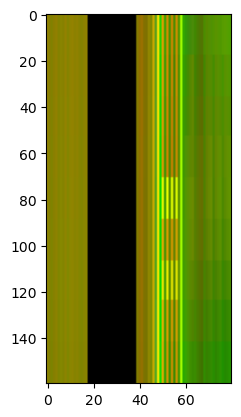

In [15]:
plt.imshow(train_ds.as_numpy_iterator().next()[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


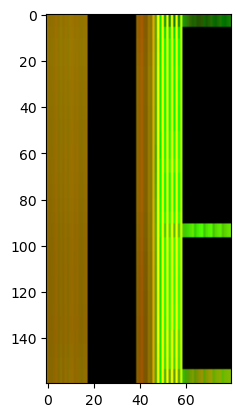

In [16]:
plt.imshow(val_ds.as_numpy_iterator().next()[0][0])

Build model

In [17]:
from resnet import add_residual_block,data_augmentation
from tensorflow.keras.layers import Dropout,Conv2D,MaxPool2D,GlobalAveragePooling2D,Dense,BatchNormalization,ReLU
from tensorflow.keras.callbacks import TensorBoard

In [18]:
log_dir = os.path.join('Logs_1')
tb_callback = TensorBoard(log_dir=log_dir)

In [21]:
Input_shape = (None,160,80,3)
Input = tf.keras.layers.Input(shape=Input_shape[1:])
x = Input

x = Conv2D(32,(3,3),padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D(pool_size=(3,3),strides=(1,1))(x)

x = data_augmentation()(x)

#Block 1
x = add_residual_block(x,32,(3,3))
x = MaxPool2D(pool_size=(3,3),strides=(2,2))(x)
x = Dropout(0.35)(x)

# Block 2
x = add_residual_block(x,64,(3,3))
x = MaxPool2D(pool_size=(3,3),strides=(2,2))(x)
x = Dropout(0.35)(x)

#Block 3
x = add_residual_block(x,128,(3,3))
x = MaxPool2D(pool_size=(3,3),strides=(2,2))(x)
x = Dropout(0.35)(x)


x = Conv2D(64,(3,3),padding='same')(x)
x = MaxPool2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
x = Dropout(0.50)(x)

x = GlobalAveragePooling2D()(x)
x = Dense(n_class,activation='softmax')(x)

model = tf.keras.Model(Input,x)

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 80, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_10 (Conv2D)             (None, 160, 80, 32)  896         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 160, 80, 32)  128        ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                            

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [49]:
model.fit(train_ds,epochs=5,validation_data=val_ds,callbacks=[tb_callback])

Layer Residual_main has arguments ['filter', 'kernel_size']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Layer Residual_main has arguments ['filter', 'kernel_size']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Epoch 1/5
573/573 [==============================] - 71s 124ms/step - loss: 0.1988 - accuracy: 0.9328 - val_loss: 1.1047 - val_accuracy: 0.8226
Epoch 2/5
573/573 [==============================] - 70s 121ms/step - loss: 0.2068 - accuracy: 0.9356 - val_loss: 1.0273 - val_accuracy: 0.8184
Epoch 3/5
573/573 [==============================] - 70s 121ms/step - loss: 0.2059 - accuracy: 0.9314 - val_loss: 1.0187 - val_accuracy: 0.8282
Epoch 4/5
573/573 [==============================] - 70s 122ms/step - loss: 0.2053 - accuracy: 0.9336 - val_loss: 1.3061 - val_accuracy: 0.8031
Epoch 5/5
573/573 [==============================] - 70s 122ms/step - loss: 0.1933 - accuracy: 0.9363 - val_loss: 1.1102 - val_accuracy: 0.8128


In [50]:
model.evaluate(test_ds)

72/72 [==============================] - 5s 69ms/step - loss: 1.2024 - accuracy: 0.8282


[1.202353835105896, 0.8282122611999512]

In [56]:
model.save("20_action_v5_acc_93_valacc_82")

INFO:tensorflow:Assets written to: 20_action_v5_acc_93_valacc_82\assets


INFO:tensorflow:Assets written to: 20_action_v5_acc_93_valacc_82\assets


In [17]:
from tensorflow.keras import models
model = models.load_model("20_action_v5_acc_93_valacc_82")

In [18]:
act_pred = []
for values in test_ds:
    y_pred = model.predict(values[0])
    y_pred = list(map(lambda X:np.argmax(X),y_pred))
    act = list(map(lambda X:np.argmax(X),values[1]))
    for value in  zip(act,y_pred):
        act_pred.append(value)


1/1 [==============================] - 0s 50ms/step


In [19]:
evaluation = pd.DataFrame(act_pred,columns=["Actual","Predict"])
evaluation.head()

,Actual,Predict
0,17,17
1,9,9
2,10,10
3,17,17
4,13,13


In [20]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

In [21]:
print(classification_report(evaluation["Actual"],evaluation["Predict"]))

              precision    recall  f1-score   support

           0       1.00      0.56      0.72        34
           1       0.88      0.74      0.80        38
           2       0.94      0.87      0.90        38
           3       0.88      0.58      0.70        38
           4       0.94      0.86      0.90        35
           5       0.83      0.92      0.88        38
           6       0.74      0.84      0.78        37
           7       0.88      0.95      0.91        38
           8       0.88      0.56      0.69        39
           9       0.93      0.74      0.82        38
          10       0.74      0.90      0.81        39
          11       0.91      0.82      0.86        38
          12       0.86      0.95      0.90        40
          13       0.90      0.85      0.88        41
          14       0.53      0.97      0.69        35
          15       0.75      0.94      0.84        35
          16       0.78      0.90      0.84        40
          17       0.83    

<Axes: >

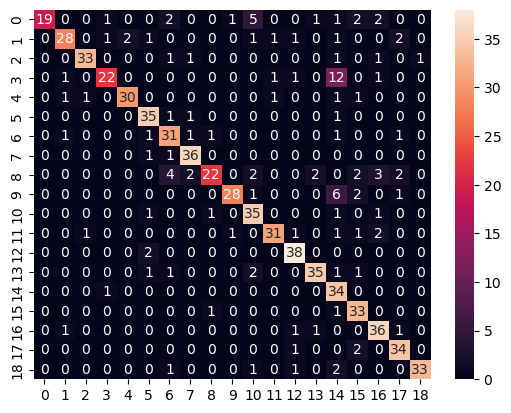

In [22]:
sns.heatmap(confusion_matrix(evaluation["Actual"],evaluation["Predict"]),annot=True)

In [24]:
model = models.load_model("20_action_v4_acc_92_valacc_82")

In [25]:
act_pred = []
for values in test_ds:
    y_pred = model.predict(values[0])
    y_pred = list(map(lambda X:np.argmax(X),y_pred))
    act = list(map(lambda X:np.argmax(X),values[1]))
    for value in  zip(act,y_pred):
        act_pred.append(value)

1/1 [==============================] - 0s 33ms/step


In [26]:
evaluation = pd.DataFrame(act_pred,columns=["Actual","Predict"])
evaluation.head()

,Actual,Predict
0,17,17
1,9,9
2,10,10
3,17,17
4,13,13


In [27]:
print(classification_report(evaluation["Actual"],evaluation["Predict"]))

              precision    recall  f1-score   support

           0       0.88      0.44      0.59        34
           1       0.83      0.66      0.74        38
           2       0.92      0.89      0.91        38
           3       0.85      0.76      0.81        38
           4       0.97      0.83      0.89        35
           5       0.88      0.92      0.90        38
           6       0.62      0.92      0.74        37
           7       0.92      0.87      0.89        38
           8       0.73      0.41      0.52        39
           9       0.79      0.82      0.81        38
          10       0.82      0.85      0.84        39
          11       0.90      0.71      0.79        38
          12       0.80      0.97      0.88        40
          13       0.92      0.85      0.89        41
          14       0.65      0.97      0.78        35
          15       0.70      0.91      0.79        35
          16       0.86      0.90      0.88        40
          17       0.76    

<Axes: >

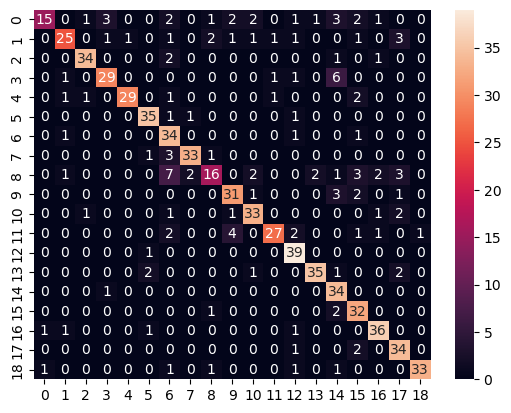

In [28]:
sns.heatmap(confusion_matrix(evaluation["Actual"],evaluation["Predict"]),annot=True)

In [32]:
import pickle

In [33]:
with open("Label_encoder_19.pkl",'wb') as file:
    pickle.dump(od_encode,file)